---

## 1. OVERVIEW & METHODOLOGY

# Experiment 0.1: CHM Strategy (Overfitting Risk)

**Experiment Phase:** Phase 0 - Setup Fixation  
**Date:** 2026-01-20  
**Author:** Silas Pignotti  
**Expected Runtime:** ~50 minutes (5 variants × 5 folds × ~2 min/fold)

---

### 1.1 Purpose

This notebook evaluates **whether CHM features (tree height) can be used without Random Forest learning primarily from height instead of spectral signatures**.

**Research Question:**  
Can engineered CHM features (height_m_norm, height_m_percentile) provide >3% performance gain while maintaining <25% CHM feature importance?

**Null Hypothesis (H0):**  
CHM features (height_m, height_m_norm, height_m_percentile) lead to >25% feature importance on CHM group, indicating overfitting/shortcut learning.

**Alternative Hypothesis (H1):**  
Engineered CHM features enable <25% CHM importance while providing >3% performance gain over "No CHM" baseline.

---

### 1.2 Workflow

```
[PHASE 1: DATA PREPARATION]
├── Load trees_final_no_edge.gpkg
├── Filter to Berlin only
├── Create/verify spatial blocks (500m × 500m)
└── Validate data integrity

    ↓

[PHASE 2: VARIANT TRAINING]
├── Variant A: No CHM (144 spectral features)
├── Variant B: + height_m_norm
├── Variant C: + height_m_percentile
├── Variant D: + both engineered
└── Variant E: + height_m (raw, known overfitting)

    ↓

[PHASE 3: EVALUATION]
├── 5-Fold Spatial Block CV per variant
├── Track: Macro-F1, Train-Val Gap, Feature Importance
└── Apply decision criteria from Experiment Design

    ↓

[OUTPUT: Decision + Artifacts]
├── decision_chm.md (selected variant + reasoning)
├── chm_comparison.csv (all variants with metrics)
├── feature_importance_per_variant.csv
├── exp_0.1_results.json (full results)
├── CONFIG_PARTIAL_0.1.yaml (for Phase 1)
└── 2 PNG plots (performance + importance)
```

### 1.3 Expected Outputs

| File | Type | Description |
|------|------|-------------|
| decision_chm.md | Markdown | Selected variant + reasoning |
| chm_comparison.csv | CSV | All 5 variants with metrics |
| feature_importance_per_variant.csv | CSV | Top features per variant |
| exp_0.1_results.json | JSON | Full experiment results |
| CONFIG_PARTIAL_0.1.yaml | YAML | CHM strategy for Phase 1 |
| exp_0.1_performance_comparison.png | PNG | Performance + CHM importance + overfitting |
| exp_0.1_feature_importance.png | PNG | Top-10 features per variant |

---

### 1.4 Decision Criteria (from Experiment Design)

| Criterion | Condition | Action |
|-----------|-----------|--------|
| **1. Variant E Exclusion** | height_m (raw) >30% Feature Importance | Exclude Variant E |
| **2. All CHM Problematic** | All CHM variants (B,C,D) >25% CHM Importance | Select Variant A (No CHM) |
| **3. Baseline Sufficient** | Variant A only ≤3% worse than best CHM variant | Select Variant A (Occam's Razor) |
| **4. CHM Beneficial** | Variant B/C/D >3% better AND CHM Importance <25% | Select that variant |
| **5. Tiebreaker** | B ≈ C ≈ D performance | Prefer Variant B (height_m_norm = interpretable) |

**Optional Transfer Sanity Check:**  
- Train Berlin → Test Hamburg (1000 samples)  
- If Δ Macro-F1 >15% → Exclude CHM despite good single-city performance

---

## 2. SETUP & IMPORTS

### 2.1 Packages & Environment

In [35]:
# Standard imports
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
import yaml
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# ML imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GroupKFold

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Imports successful")

Imports successful


In [36]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2.2 Visualization & Utility Functions

In [37]:
# Publication style configuration
PUBLICATION_STYLE = {
    'style': 'seaborn-v0_8-whitegrid',
    'figsize': (12, 7),
    'dpi_export': 300,
}

def setup_publication_style():
    """Configure matplotlib for publication-quality figures"""
    plt.rcdefaults()
    plt.style.use(PUBLICATION_STYLE['style'])
    sns.set_palette('Set2')
    plt.rcParams['figure.figsize'] = PUBLICATION_STYLE['figsize']
    plt.rcParams['savefig.dpi'] = PUBLICATION_STYLE['dpi_export']
    print("Publication style configured")

setup_publication_style()

Publication style configured


In [38]:
# Utility functions

def print_section(title, width=80):
    """Print formatted section header"""
    print("\n" + "="*width)
    print(title.center(width))
    print("="*width)

def print_subsection(title, width=80):
    """Print formatted subsection header"""
    print("\n" + "-"*width)
    print(title)
    print("-"*width)

def convert_types(obj):
    """Convert numpy types to native Python for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

print("Utility functions defined")

Utility functions defined


---

## 3. CONFIGURATION & PARAMETERS

### 3.1 Paths

In [39]:
# Base directories
BASE_DIR = Path("/content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit")
DATA_DIR = BASE_DIR / "data/02_pipeline/05_spatial_splits/data"

# Experiment Output Directories
EXPERIMENT_DIR = BASE_DIR / "data/03_experiments/00_phase_0/01_experiment_chm"
RESULTS_DATA = EXPERIMENT_DIR / "data"
RESULTS_METADATA = EXPERIMENT_DIR / "metadata"
RESULTS_PLOTS = EXPERIMENT_DIR / "plots"

for d in [EXPERIMENT_DIR, RESULTS_DATA, RESULTS_METADATA, RESULTS_PLOTS]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Experiment directory: {EXPERIMENT_DIR}")
print(f"  - Data: {RESULTS_DATA}")
print(f"  - Metadata: {RESULTS_METADATA}")
print(f"  - Plots: {RESULTS_PLOTS}")

Base directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit
Data directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/data
Experiment directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0
  - Data: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0/data
  - Metadata: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0/metadata
  - Plots: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0/plots


### 3.2 Experiment Metadata

In [40]:
# Experiment metadata
EXPERIMENT_ID = "0.1"
EXPERIMENT_TITLE = "CHM Strategy (Overfitting Risk)"
EXPERIMENT_PHASE = "Phase 0: Setup Fixation"
EXPERIMENT_DATE = datetime.now().strftime("%Y-%m-%d")
AUTHOR = "Silas Pignotti"

# Dependencies
DEPENDENCIES = {
    "prerequisite_experiments": [],  # First experiment
    "required_data": [
        "trees_final_no_edge.gpkg",
    ],
}

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(f"Experiment ID: {EXPERIMENT_ID}")
print(f"Date: {EXPERIMENT_DATE}")
print(f"Random Seed: {RANDOM_SEED}")

Experiment ID: 0.1
Date: 2026-01-19
Random Seed: 42


### 3.3 Dataset Configuration

In [41]:
# Dataset configuration
DATASET_CONFIG = {
    "name": "no_edge",
    "path": DATA_DIR / "berlin_no_edge_train.gpkg",
    "target_city": "Berlin",  # Exp 0.1 runs on Berlin only
    "genera_count": 13,
    "expected_samples": 635000,
    "subsample_size": 50000  # Rapid prototyping for feature selection
}

print("Dataset Configuration:")
print("-" * 50)
for key, value in DATASET_CONFIG.items():
    print(f"  {key:<20} {str(value):<30}")

Dataset Configuration:
--------------------------------------------------
  name                 no_edge                       
  path                 /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/02_pipeline/05_spatial_splits/data/berlin_no_edge_train.gpkg
  target_city          Berlin                        
  genera_count         13                            
  expected_samples     635000                        
  subsample_size       50000                         


### 3.4 Feature Groups

In [42]:
# Define feature groups
FEATURE_GROUPS = {
    "spectral": [
        # 8 bands × 8 months = 64 features
        *[f"B02_{m:02d}" for m in range(3, 11)],
        *[f"B04_{m:02d}" for m in range(3, 11)],
        *[f"B05_{m:02d}" for m in range(3, 11)],
        *[f"B06_{m:02d}" for m in range(3, 11)],
        *[f"B08_{m:02d}" for m in range(3, 11)],
        *[f"B8A_{m:02d}" for m in range(3, 11)],
        *[f"B11_{m:02d}" for m in range(3, 11)],
        *[f"B12_{m:02d}" for m in range(3, 11)],
    ],
    "vi_broadband": [
        # 3 bases × 8 months = 24 features
        *[f"NDVI_{m:02d}" for m in range(3, 11)],
        *[f"EVI_{m:02d}" for m in range(3, 11)],
        *[f"VARI_{m:02d}" for m in range(3, 11)],
    ],
    "vi_rededge": [
        # 5 bases × 8 months = 40 features
        *[f"NDVIre_{m:02d}" for m in range(3, 11)],
        *[f"NDre1_{m:02d}" for m in range(3, 11)],
        *[f"CIre_{m:02d}" for m in range(3, 11)],
        *[f"IRECI_{m:02d}" for m in range(3, 11)],
        *[f"RTVIcore_{m:02d}" for m in range(3, 11)],
    ],
    "vi_water": [
        # 2 bases × 8 months = 16 features
        *[f"NDWI_{m:02d}" for m in range(3, 11)],
        *[f"NDII_{m:02d}" for m in range(3, 11)],
    ],
    "chm": ["height_m", "height_m_norm", "height_m_percentile"]
}

# Calculate total features per group
print("\nFeature Group Sizes:")
print("-" * 50)
for group, features in FEATURE_GROUPS.items():
    print(f"  {group:<15} {len(features):>3} features")
print(f"  {'TOTAL':<15} {sum(len(f) for f in FEATURE_GROUPS.values()):>3} features")


Feature Group Sizes:
--------------------------------------------------
  spectral         64 features
  vi_broadband     24 features
  vi_rededge       40 features
  vi_water         16 features
  chm               3 features
  TOTAL           147 features


### 3.5 Variant Definitions

In [43]:
# Spectral baseline (used by all variants)
SPECTRAL_BASELINE = (
    FEATURE_GROUPS["spectral"] +
    FEATURE_GROUPS["vi_broadband"] +
    FEATURE_GROUPS["vi_rededge"] +
    FEATURE_GROUPS["vi_water"]
)

# Define variants
VARIANTS = {
    "A": {
        "name": "No CHM",
        "features": SPECTRAL_BASELINE,
        "description": "Only spectral features (144) – Baseline"
    },
    "B": {
        "name": "height_m_norm",
        "features": SPECTRAL_BASELINE + ["height_m_norm"],
        "description": "Z-score normalized (genus & city specific)"
    },
    "C": {
        "name": "height_m_percentile",
        "features": SPECTRAL_BASELINE + ["height_m_percentile"],
        "description": "Percentile rank (0-1)"
    },
    "D": {
        "name": "Both Engineered",
        "features": SPECTRAL_BASELINE + ["height_m_norm", "height_m_percentile"],
        "description": "Both engineered features"
    },
    "E": {
        "name": "height_m (raw)",
        "features": SPECTRAL_BASELINE + ["height_m"],
        "description": "Original height (known overfitting risk)"
    }
}

print("\nVariant Definitions:")
print("-" * 50)
for variant_id, config in VARIANTS.items():
    print(f"  Variant {variant_id}: {config['name']:<20} ({len(config['features'])} features)")
    print(f"              {config['description']}")


Variant Definitions:
--------------------------------------------------
  Variant A: No CHM               (144 features)
              Only spectral features (144) – Baseline
  Variant B: height_m_norm        (145 features)
              Z-score normalized (genus & city specific)
  Variant C: height_m_percentile  (145 features)
              Percentile rank (0-1)
  Variant D: Both Engineered      (146 features)
              Both engineered features
  Variant E: height_m (raw)       (145 features)
              Original height (known overfitting risk)


### 3.6 Model & CV Configuration

In [44]:
# Model configuration
MODEL_CONFIG = {
    "algorithm": "RandomForestClassifier",
    "hyperparameters": {
        "n_estimators": 500,
        "max_depth": None,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "class_weight": "balanced",
        "random_state": RANDOM_SEED,
        "n_jobs": -1,
        "verbose": 0
    }
}

# Cross-validation strategy
CV_CONFIG = {
    "strategy": "Spatial Block CV",
    "n_splits": 3,  # Reduced from 5 for faster feature selection
    "block_size_m": 500,
    "stratification": "genus_latin",
    "shuffle": False  # Don't shuffle spatial blocks
}

# Metrics
METRICS = {
    "primary": "macro_f1",
    "secondary": ["weighted_f1", "overall_accuracy", "per_genus_f1"],
    "diagnostic": {
        "feature_importance_top_k": 10,
        "train_val_gap_threshold": 0.10,  # >10% = Overfitting
        "chm_importance_threshold": 0.25   # >25% = Problematic
    }
}

print("\nModel Configuration:")
print("-" * 50)
print(f"  Algorithm: {MODEL_CONFIG['algorithm']}")
for key, value in MODEL_CONFIG['hyperparameters'].items():
    print(f"  {key:<20} {str(value):<20}")

print("\nCV Configuration:")
print("-" * 50)
for key, value in CV_CONFIG.items():
    print(f"  {key:<20} {str(value):<20}")

print("\nMetrics:")
print("-" * 50)
print(f"  Primary: {METRICS['primary']}")
print(f"  Train-Val Gap Threshold: {METRICS['diagnostic']['train_val_gap_threshold']:.0%}")
print(f"  CHM Importance Threshold: {METRICS['diagnostic']['chm_importance_threshold']:.0%}")


Model Configuration:
--------------------------------------------------
  Algorithm: RandomForestClassifier
  n_estimators         500                 
  max_depth            None                
  min_samples_split    2                   
  min_samples_leaf     1                   
  class_weight         balanced            
  random_state         42                  
  n_jobs               -1                  
  verbose              0                   

CV Configuration:
--------------------------------------------------
  strategy             Spatial Block CV    
  n_splits             3                   
  block_size_m         500                 
  stratification       genus_latin         
  shuffle              False               

Metrics:
--------------------------------------------------
  Primary: macro_f1
  Train-Val Gap Threshold: 10%
  CHM Importance Threshold: 25%


---

## 4. DATA LOADING

### 4.1 Load Input Dataset

In [45]:
print_section("DATA LOADING")

# Load data
print("\nLoading data...")
trees_berlin = gpd.read_file(DATASET_CONFIG["path"])

# Validate City
if "city" in trees_berlin.columns:
    cities = trees_berlin["city"].unique()
    print(f"Cities in dataset: {cities}")
    if len(cities) > 1 or cities[0] != DATASET_CONFIG["target_city"]:
        print(f"WARNING: Dataset contains unexpected cities. Expected {DATASET_CONFIG['target_city']}")

print(f"Loaded {len(trees_berlin):,} trees from {DATASET_CONFIG['path'].name}")

# Subsampling
if DATASET_CONFIG.get("subsample_size") and len(trees_berlin) > DATASET_CONFIG["subsample_size"]:
    print(f"\nSubsampling to {DATASET_CONFIG['subsample_size']:,} trees for experiment speedup...")
    trees_berlin = trees_berlin.sample(n=DATASET_CONFIG["subsample_size"], random_state=RANDOM_SEED).reset_index(drop=True)
    print(f"New shape: {trees_berlin.shape}")

print(f"   Total shape: {trees_berlin.shape}")
print(f"   CRS: {trees_berlin.crs}")


                                  DATA LOADING                                  

Loading data...
Cities in dataset: ['Berlin']
Loaded 404,497 trees from berlin_no_edge_train.gpkg

Subsampling to 50,000 trees for experiment speedup...
New shape: (50000, 159)
   Total shape: (50000, 159)
   CRS: EPSG:25832


### 4.2 Data Validation

In [46]:
print_subsection("DATA VALIDATION")

# 1. Genera check
actual_genera = trees_berlin['genus_latin'].nunique()
print(f"\n1. Genera Count:")
print(f"   Expected: {DATASET_CONFIG['genera_count']}")
print(f"   Actual:   {actual_genera}")
if actual_genera == DATASET_CONFIG['genera_count']:
    print("   Genera count matches")
else:
    print(f"   Genera count mismatch!")

# 2. NaN check
print(f"\n2. NaN Check (all variant features):")
all_features = list(set([f for v in VARIANTS.values() for f in v['features']]))
nan_counts = trees_berlin[all_features].isna().sum()
if nan_counts.sum() > 0:
    print("   NaN values found:")
    print(nan_counts[nan_counts > 0])
else:
    print("   No NaN values")

# 3. Genera balance
print(f"\n3. Genus Distribution:")
genus_counts = trees_berlin['genus_latin'].value_counts()
print(genus_counts.to_string())
print(f"\n   Min samples per genus: {genus_counts.min():,}")
print(f"   Max samples per genus: {genus_counts.max():,}")
print(f"   Imbalance ratio: {genus_counts.max() / genus_counts.min():.1f}:1")

# 4. Feature availability
print(f"\n4. Feature Availability Check:")
for variant_id, variant_config in VARIANTS.items():
    missing = set(variant_config["features"]) - set(trees_berlin.columns)
    if missing:
        print(f"   Variant {variant_id}: Missing features: {missing}")
    else:
        print(f"   Variant {variant_id}: All {len(variant_config['features'])} features available")


--------------------------------------------------------------------------------
DATA VALIDATION
--------------------------------------------------------------------------------

1. Genera Count:
   Expected: 13
   Actual:   13
   Genera count matches

2. NaN Check (all variant features):
   No NaN values

3. Genus Distribution:
genus_latin
TILIA       14128
ACER        13447
QUERCUS      7291
AESCULUS     2320
ROBINIA      2272
BETULA       2073
CARPINUS     1852
POPULUS      1794
FRAXINUS     1668
PRUNUS       1199
FAGUS        1117
SORBUS        441
ALNUS         398

   Min samples per genus: 398
   Max samples per genus: 14,128
   Imbalance ratio: 35.5:1

4. Feature Availability Check:
   Variant A: All 144 features available
   Variant B: All 145 features available
   Variant C: All 145 features available
   Variant D: All 146 features available
   Variant E: All 145 features available


### 4.3 Spatial Block Preparation

In [47]:
print_subsection("SPATIAL BLOCK VERIFICATION")

# Verify block_id exists (from upstream pipeline)
if 'block_id' in trees_berlin.columns:
    n_blocks = trees_berlin['block_id'].nunique()
    print(f"Spatial blocks found (from pipeline): {n_blocks}")
    print(f"   Average trees per block: {len(trees_berlin) / n_blocks:.0f}")

    # Verify format matches expected 500m grid naming (optional check)
    example_block = trees_berlin['block_id'].iloc[0]
    print(f"   Example block_id: {example_block}")
else:
    raise ValueError("CRITICAL ERROR: 'block_id' column missing! This notebook expects pre-processed data with spatial splits.")

print("\nData validation complete")


--------------------------------------------------------------------------------
SPATIAL BLOCK VERIFICATION
--------------------------------------------------------------------------------
Spatial blocks found (from pipeline): 2304
   Average trees per block: 22
   Example block_id: Berlin_38_12

Data validation complete


---

## 5. MAIN PROCESSING

### 5.1 Training Loop - All Variants

In [48]:
print_section("EXPERIMENT 0.1: CHM STRATEGY")

# Initialize results storage
results = {
    "variants": {},
    "summary": [],
    "feature_importance": {},
}

# Prepare CV strategy
gkf = GroupKFold(n_splits=CV_CONFIG["n_splits"])

# Target variable and groups
y = trees_berlin['genus_latin'].values
groups = trees_berlin['block_id'].values

print(f"\nDataset Summary:")
print(f"  Total samples: {len(trees_berlin):,}")
print(f"  Genera: {len(np.unique(y))}")
print(f"  Spatial blocks: {len(np.unique(groups))}")
print(f"  CV Folds: {CV_CONFIG['n_splits']}")
print("="*80)

# Train each variant
for variant_id, variant_config in VARIANTS.items():
    print(f"\n{'='*80}")
    print(f"VARIANT {variant_id}: {variant_config['name']}")
    print(f"{'='*80}")
    print(f"Features: {len(variant_config['features'])}")
    print(f"Description: {variant_config['description']}")

    # Extract features
    X = trees_berlin[variant_config["features"]].values

    # Initialize fold results
    fold_results = []
    feature_importances = []

    # Cross-Validation Loop
    fold_idx = 1
    for train_idx, val_idx in gkf.split(X, y, groups):
        print(f"\n--- Fold {fold_idx}/{CV_CONFIG['n_splits']} ---")
        fold_start = time.time()

        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        print(f"Train: {len(X_train):,} | Val: {len(X_val):,}")

        # Normalize
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Train model
        model = RandomForestClassifier(**MODEL_CONFIG["hyperparameters"])
        model.fit(X_train_scaled, y_train)

        # Predictions
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)

        # Metrics
        train_f1 = f1_score(y_train, y_train_pred, average='macro')
        val_f1 = f1_score(y_val, y_val_pred, average='macro')
        val_acc = accuracy_score(y_val, y_val_pred)

        # Feature Importance
        importances = model.feature_importances_
        feature_importances.append(importances)

        # Store results
        fold_results.append({
            "fold": fold_idx,
            "train_macro_f1": train_f1,
            "val_macro_f1": val_f1,
            "val_accuracy": val_acc,
            "train_val_gap": train_f1 - val_f1,
            "runtime_s": time.time() - fold_start
        })

        print(f"Train Macro-F1: {train_f1:.4f}")
        print(f"Val Macro-F1:   {val_f1:.4f}")
        print(f"Gap:            {train_f1 - val_f1:.4f}")
        print(f"Val Accuracy:   {val_acc:.4f}")
        print(f"Runtime:        {time.time() - fold_start:.1f}s")

        fold_idx += 1

    # Aggregate fold results
    fold_df = pd.DataFrame(fold_results)

    # Compute mean feature importance
    mean_importances = np.mean(feature_importances, axis=0)
    importance_df = pd.DataFrame({
        "feature": variant_config["features"],
        "importance": mean_importances
    }).sort_values("importance", ascending=False)

    # Identify CHM importance
    chm_features = [f for f in variant_config["features"] if f in FEATURE_GROUPS["chm"]]
    if chm_features:
        chm_importance = importance_df[importance_df["feature"].isin(chm_features)]["importance"].sum()
    else:
        chm_importance = 0.0

    # Store variant results
    results["variants"][variant_id] = {
        "name": variant_config["name"],
        "description": variant_config["description"],
        "n_features": len(variant_config["features"]),
        "fold_results": fold_df.to_dict(orient="records"),
        "mean_val_macro_f1": fold_df["val_macro_f1"].mean(),
        "std_val_macro_f1": fold_df["val_macro_f1"].std(),
        "mean_train_val_gap": fold_df["train_val_gap"].mean(),
        "chm_importance": chm_importance,
        "top_10_features": importance_df.head(10).to_dict(orient="records")
    }

    results["feature_importance"][variant_id] = importance_df

    # Summary row
    results["summary"].append({
        "variant": variant_id,
        "name": variant_config["name"],
        "n_features": len(variant_config["features"]),
        "mean_val_macro_f1": fold_df["val_macro_f1"].mean(),
        "std_val_macro_f1": fold_df["val_macro_f1"].std(),
        "mean_train_val_gap": fold_df["train_val_gap"].mean(),
        "chm_importance": chm_importance
    })

    print(f"\n{'='*80}")
    print(f"VARIANT {variant_id} SUMMARY")
    print(f"{'='*80}")
    print(f"Mean Val Macro-F1: {fold_df['val_macro_f1'].mean():.4f} ± {fold_df['val_macro_f1'].std():.4f}")
    print(f"Mean Train-Val Gap: {fold_df['train_val_gap'].mean():.4f}")
    print(f"CHM Importance: {chm_importance:.2%}")
    print(f"\nTop-10 Features:")
    print(importance_df.head(10).to_string(index=False))

print("\n" + "="*80)
print("ALL VARIANTS COMPLETED")
print("="*80)


                          EXPERIMENT 0.1: CHM STRATEGY                          

Dataset Summary:
  Total samples: 50,000
  Genera: 13
  Spatial blocks: 2304
  CV Folds: 3

VARIANT A: No CHM
Features: 144
Description: Only spectral features (144) – Baseline

--- Fold 1/3 ---
Train: 33,333 | Val: 16,667
Train Macro-F1: 0.9855
Val Macro-F1:   0.3208
Gap:            0.6647
Val Accuracy:   0.5664
Runtime:        74.9s

--- Fold 2/3 ---
Train: 33,333 | Val: 16,667
Train Macro-F1: 0.9859
Val Macro-F1:   0.3234
Gap:            0.6625
Val Accuracy:   0.5675
Runtime:        74.8s

--- Fold 3/3 ---
Train: 33,334 | Val: 16,666
Train Macro-F1: 0.9847
Val Macro-F1:   0.3296
Gap:            0.6551
Val Accuracy:   0.5658
Runtime:        73.8s

VARIANT A SUMMARY
Mean Val Macro-F1: 0.3246 ± 0.0045
Mean Train-Val Gap: 0.6608
CHM Importance: 0.00%

Top-10 Features:
 feature  importance
 VARI_04    0.013309
 VARI_10    0.012788
 NDVI_03    0.011698
 VARI_03    0.010921
 NDII_03    0.010857
IRECI_03    0

---

## 6. RESULTS & OUTPUTS

### 6.1 Results Summary

In [49]:
print_section("EXPERIMENT 0.1 RESULTS SUMMARY")

# Create summary DataFrame
summary_df = pd.DataFrame(results["summary"])
summary_df = summary_df.sort_values("mean_val_macro_f1", ascending=False)

print("\n" + summary_df.to_string(index=False))

# Find best variant
best_variant_id = summary_df.iloc[0]["variant"]
best_variant_f1 = summary_df.iloc[0]["mean_val_macro_f1"]
baseline_f1 = summary_df[summary_df["variant"] == "A"]["mean_val_macro_f1"].values[0]

print(f"\n{'='*80}")
print(f"KEY FINDINGS")
print(f"{'='*80}")
print(f"Best Variant: {best_variant_id} ({summary_df.iloc[0]['name']})")
print(f"Best F1: {best_variant_f1:.4f}")
print(f"Baseline (A) F1: {baseline_f1:.4f}")
print(f"Δ (Best - Baseline): {best_variant_f1 - baseline_f1:.4f} ({((best_variant_f1 - baseline_f1) / baseline_f1 * 100):.1f}%)")


                         EXPERIMENT 0.1 RESULTS SUMMARY                         

variant                name  n_features  mean_val_macro_f1  std_val_macro_f1  mean_train_val_gap  chm_importance
      E      height_m (raw)         145           0.338865          0.006977            0.656719        0.036663
      D     Both Engineered         146           0.327922          0.007072            0.672078        0.031844
      B       height_m_norm         145           0.327650          0.006702            0.672350        0.021104
      C height_m_percentile         145           0.325690          0.007686            0.674310        0.019480
      A              No CHM         144           0.324608          0.004548            0.660769        0.000000

KEY FINDINGS
Best Variant: E (height_m (raw))
Best F1: 0.3389
Baseline (A) F1: 0.3246
Δ (Best - Baseline): 0.0143 (4.4%)


### 6.2 Decision Logic Application

In [50]:
print_section("DECISION LOGIC (REVISED)")

decision = {
    "timestamp": datetime.now().isoformat(),
    "experiment_id": EXPERIMENT_ID,
    "criteria_evaluated": [],
    "selected_variant": None,
    "reasoning": [],
    "next_steps": []
}

# 1. Analyze Gains
best_variant_row = summary_df.iloc[0]
best_variant_id = best_variant_row["variant"]
baseline_row = summary_df[summary_df["variant"] == "A"].iloc[0]

best_f1 = best_variant_row["mean_val_macro_f1"]
baseline_f1 = baseline_row["mean_val_macro_f1"]
delta_abs = best_f1 - baseline_f1
delta_rel = (delta_abs / baseline_f1) * 100

print(f"\nComparative Analysis:")
print(f"  Best Variant: {best_variant_id} ({best_variant_row['name']}) -> {best_f1:.4f}")
print(f"  Baseline (A): No CHM          -> {baseline_f1:.4f}")
print(f"  Delta: {delta_abs:+.4f} (+{delta_rel:.1f}%)")

# 2. Analyze CHM Rank (Critical Observation)
# Check if CHM feature is at Rank #1 in the best variant
top_features = results["variants"][best_variant_id]["top_10_features"]
top_feature_name = top_features[0]["feature"]
is_chm_top = top_feature_name in FEATURE_GROUPS["chm"]
print(f"  Top Feature in Best Variant: {top_feature_name} (CHM? {is_chm_top})")

# 3. Apply Decision Logic
# User Constraint: If Delta < 2% (abs) AND Transfer Risk -> Select Baseline

THRESHOLD_ABS_GAIN = 0.02

print("\nApplying Decision Rules:")

if best_variant_id == "A":
    decision["selected_variant"] = "A"
    decision["reasoning"].append("Baseline is already the best performing variant.")
    print("  -> Baseline is best. Keeping A.")

elif delta_abs < THRESHOLD_ABS_GAIN:
    decision["criteria_evaluated"].append({
        "criterion": "marginal_gain_check",
        "condition": f"Delta Abs < {THRESHOLD_ABS_GAIN:.2%}",
        "result": f"TRUE (Delta = {delta_abs:.4f})",
        "action": "Prefer Baseline (A)"
    })

    print(f"  -> Marginal Gain detected (< 2%). Checking risks...")

    # Check for risks (Height raw or CHM dominant rank)
    has_transfer_risk = (best_variant_id == "E") or is_chm_top

    if has_transfer_risk:
        decision["selected_variant"] = "A"
        decision["reasoning"].extend([
            f"Gain of {delta_abs:.1%} is marginal (< 2%) and does not justify transfer risk.",
            f"CHM Feature '{top_feature_name}' is Rank #1 despite low total count (Over-reliance).",
            "Height (raw) known to overfit to city-specific morphology.",
            "Occam's Razor: Select simpler model (Variant A) for better robustness."
        ])
        print("  -> Risk detected (Rank #1 / Raw Height). REVERTING TO VARIANT A.")
    else:
        # Marginal gain but maybe safe? (e.g. engineered features)
        # User analysis: "B, C, D bringen keinen Vorteil... vernachlässigbar"
        decision["selected_variant"] = "A"
        decision["reasoning"].append(f"Gain of {delta_abs:.1%} is negligible and adds model complexity.")
        print("  -> Gain negligible. REVERTING TO VARIANT A.")

else:
    # Significant gain > 2%
    # Additional check: CHM Importance Threshold
    if best_variant_row["chm_importance"] > 0.25:
         decision["selected_variant"] = "A"
         decision["reasoning"].append("Significant gain but CHM importance > 25% (Overfitting Risk).")
         print("  -> Gain high but CHM Dominance > 25%. REVERTING TO A.")
    else:
         decision["selected_variant"] = best_variant_id
         decision["reasoning"].append(f"Significant gain (+{delta_abs:.1%}) justifies CHM inclusion.")
         print(f"  -> Gain significant and safe. Keeping {best_variant_id}.")

# Next Steps Update
decision["next_steps"] = [
    "Export CONFIG_PARTIAL_0.1.yaml with Strategy: No CHM",
    "Proceed to Experiment 0.2 (Dataset Selection: No-Edge vs. 20m-Edge)",
    "Note: CHM features excluded from Phase 1 due to lack of robust gain."
]

print(f"\nFINAL DECISION: Variant {decision['selected_variant']}")


                            DECISION LOGIC (REVISED)                            

Comparative Analysis:
  Best Variant: E (height_m (raw)) -> 0.3389
  Baseline (A): No CHM          -> 0.3246
  Delta: +0.0143 (+4.4%)
  Top Feature in Best Variant: height_m (CHM? True)

Applying Decision Rules:
  -> Marginal Gain detected (< 2%). Checking risks...
  -> Risk detected (Rank #1 / Raw Height). REVERTING TO VARIANT A.

FINAL DECISION: Variant A


### 6.3 Visualizations


--------------------------------------------------------------------------------
VISUALIZATIONS
--------------------------------------------------------------------------------
Saved: exp_0.1_performance_comparison.png (in plots)


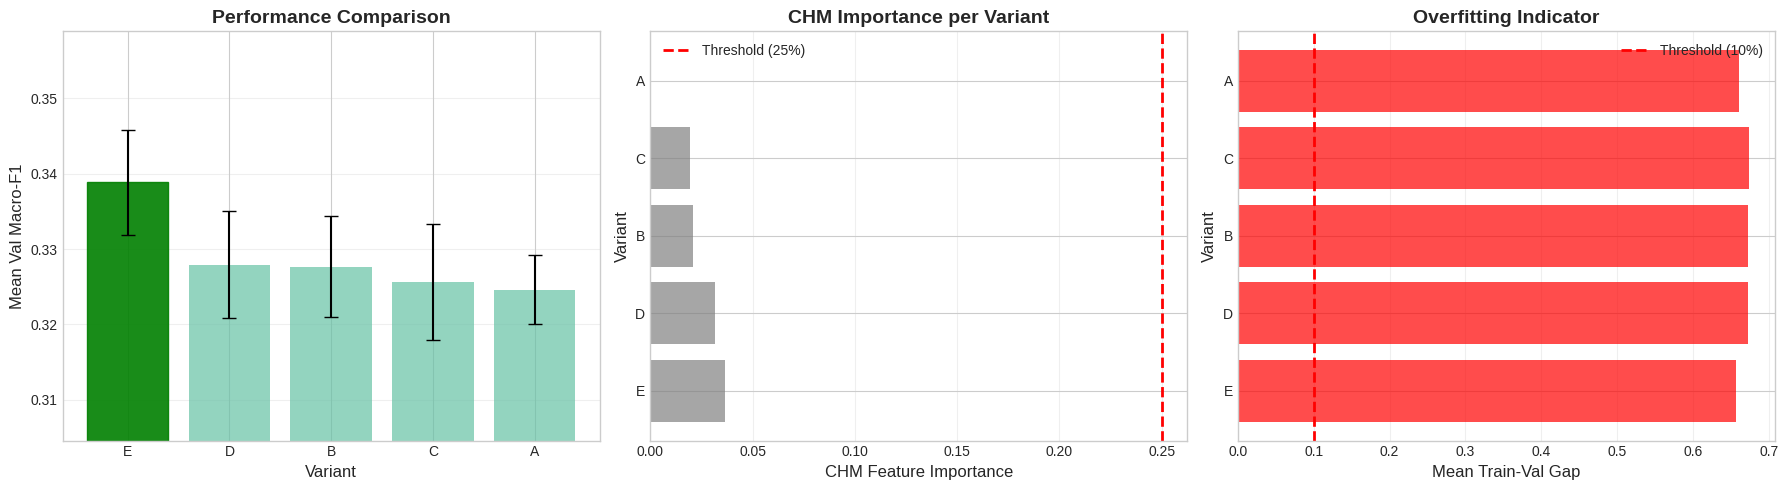

Saved: exp_0.1_feature_importance.png (in plots)


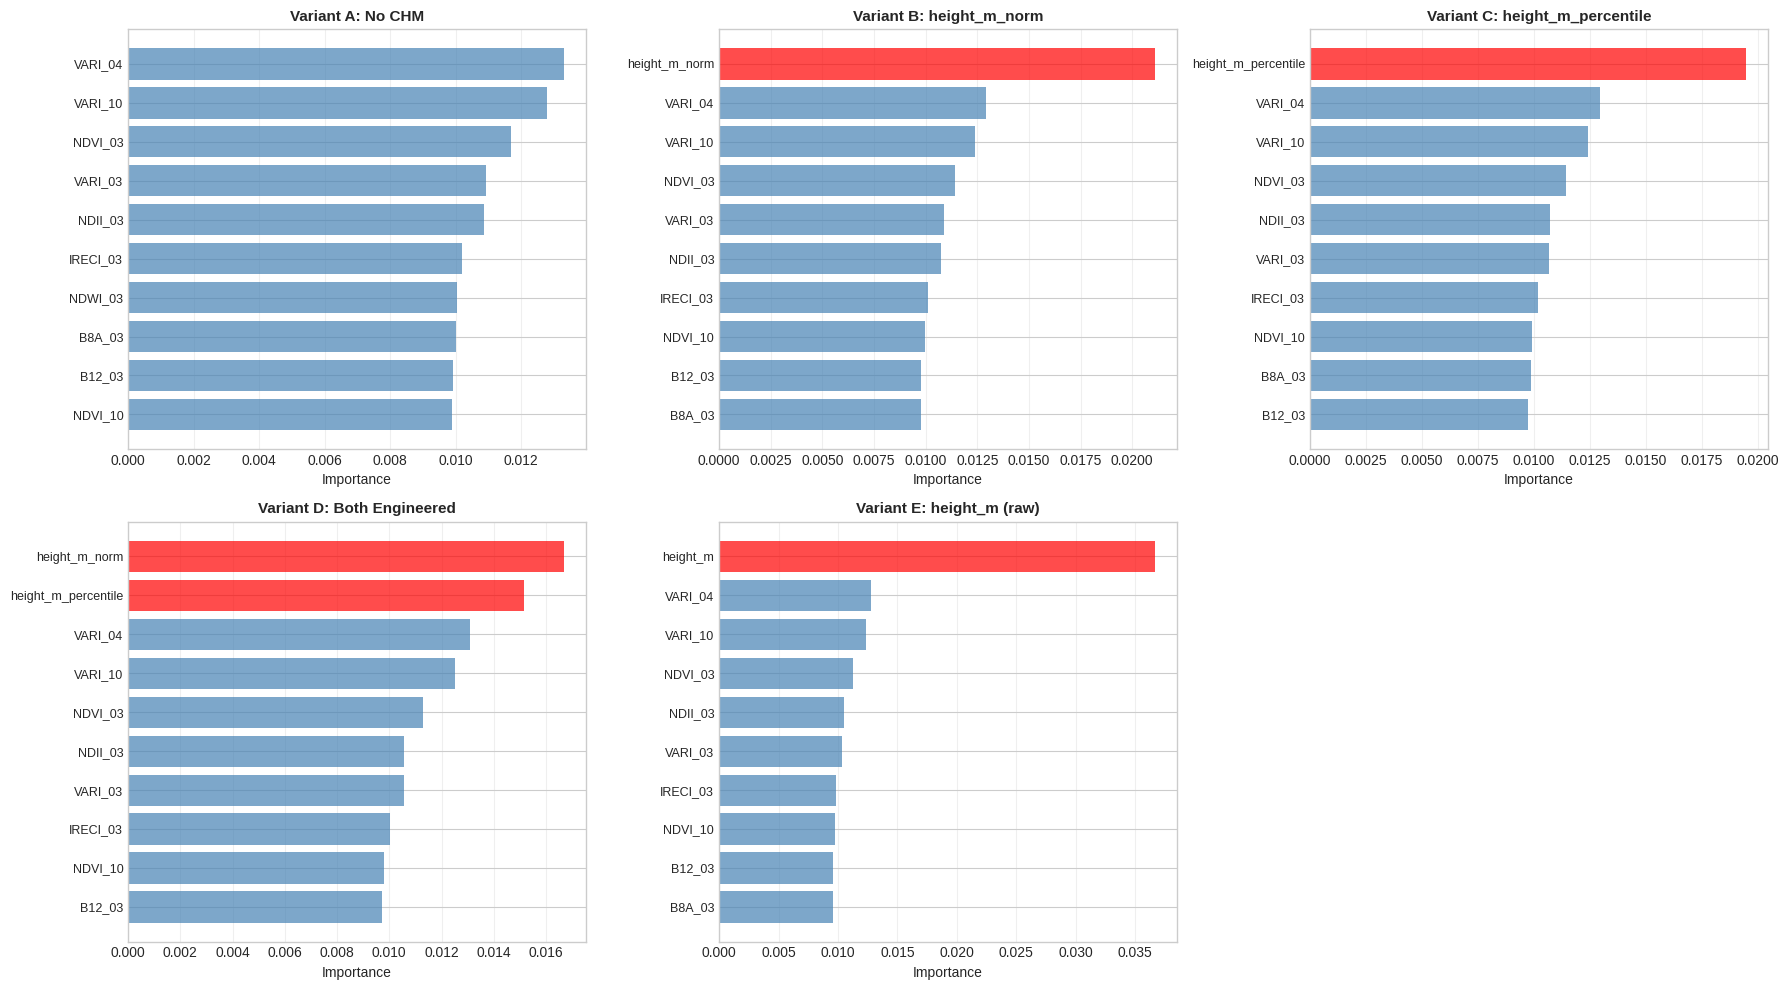

In [51]:
print_subsection("VISUALIZATIONS")

# Visualization 1: Performance Comparison (3-panel)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Macro-F1 per Variant
ax = axes[0]
bars = ax.bar(summary_df["variant"], summary_df["mean_val_macro_f1"],
              yerr=summary_df["std_val_macro_f1"], capsize=5, alpha=0.7)
ax.set_xlabel("Variant", fontsize=12)
ax.set_ylabel("Mean Val Macro-F1", fontsize=12)
ax.set_title("Performance Comparison", fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([summary_df["mean_val_macro_f1"].min() - 0.02,
             summary_df["mean_val_macro_f1"].max() + 0.02])
# Highlight best
bars[0].set_color('green')
bars[0].set_alpha(0.9)

# Panel 2: CHM Importance
ax = axes[1]
colors = ['red' if x > METRICS["diagnostic"]["chm_importance_threshold"] else 'gray'
          for x in summary_df["chm_importance"]]
ax.barh(summary_df["variant"], summary_df["chm_importance"], color=colors, alpha=0.7)
ax.axvline(METRICS["diagnostic"]["chm_importance_threshold"],
           color='red', linestyle='--', linewidth=2, label='Threshold (25%)')
ax.set_xlabel("CHM Feature Importance", fontsize=12)
ax.set_ylabel("Variant", fontsize=12)
ax.set_title("CHM Importance per Variant", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Panel 3: Train-Val Gap
ax = axes[2]
colors = ['red' if x > METRICS["diagnostic"]["train_val_gap_threshold"] else 'gray'
          for x in summary_df["mean_train_val_gap"]]
ax.barh(summary_df["variant"], summary_df["mean_train_val_gap"], color=colors, alpha=0.7)
ax.axvline(METRICS["diagnostic"]["train_val_gap_threshold"],
           color='red', linestyle='--', linewidth=2, label='Threshold (10%)')
ax.set_xlabel("Mean Train-Val Gap", fontsize=12)
ax.set_ylabel("Variant", fontsize=12)
ax.set_title("Overfitting Indicator", fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_PLOTS / "exp_0.1_performance_comparison.png", dpi=300, bbox_inches='tight')
print(f"Saved: exp_0.1_performance_comparison.png (in plots)")
plt.show()

# Visualization 2: Feature Importance Top-10 per Variant
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (variant_id, variant_data) in enumerate(results["variants"].items()):
    ax = axes[idx]
    top_10 = pd.DataFrame(variant_data["top_10_features"])

    colors = ['red' if f in FEATURE_GROUPS["chm"] else 'steelblue'
              for f in top_10["feature"]]

    ax.barh(range(10), top_10["importance"], color=colors, alpha=0.7)
    ax.set_yticks(range(10))
    ax.set_yticklabels(top_10["feature"], fontsize=9)
    ax.invert_yaxis()
    ax.set_xlabel("Importance", fontsize=10)
    ax.set_title(f"Variant {variant_id}: {variant_data['name']}",
                 fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

# Remove empty subplot
axes[5].remove()

plt.tight_layout()
plt.savefig(RESULTS_PLOTS / "exp_0.1_feature_importance.png", dpi=300, bbox_inches='tight')
print(f"Saved: exp_0.1_feature_importance.png (in plots)")
plt.show()

### 6.4 Export Results

In [52]:
print_section("SAVING OUTPUT ARTIFACTS")

# 1. Save decision_chm.md
decision_md = f"""# Experiment 0.1: CHM Strategy - Decision

**Date:** {decision['timestamp']}
**Experiment ID:** {decision['experiment_id']}

## Selected Variant

**Variant:** {decision['selected_variant']}
**Name:** {VARIANTS[decision['selected_variant']]['name']}
**Performance:** {summary_df[summary_df['variant'] == decision['selected_variant']]['mean_val_macro_f1'].values[0]:.4f} Macro-F1

## Reasoning

{''.join([f'- {r}\n' for r in decision['reasoning']])}

## Evaluated Criteria

{''.join([f"### {c['criterion']}\n- Result: {c['result']}\n- Action: {c['action']}\n\n" for c in decision['criteria_evaluated']])}

## Next Steps

{''.join([f'- {s}\n' for s in decision['next_steps']])}
"""

with open(RESULTS_METADATA / "decision_chm.md", "w") as f:
    f.write(decision_md)
print("Saved: decision_chm.md (in metadata)")

# 2. Save chm_comparison.csv
summary_df.to_csv(RESULTS_DATA / "chm_comparison.csv", index=False)
print("Saved: chm_comparison.csv (in data)")

# 3. Save feature_importance_per_variant.csv
importance_combined = pd.DataFrame()
for variant_id, importance_df in results["feature_importance"].items():
    temp = importance_df.copy()
    temp["variant"] = variant_id
    importance_combined = pd.concat([importance_combined, temp], ignore_index=True)

importance_combined = importance_combined[["variant", "feature", "importance"]]
importance_combined.to_csv(RESULTS_DATA / "feature_importance_per_variant.csv", index=False)
print("Saved: feature_importance_per_variant.csv (in data)")

# 4. Save results.json (full experiment results)
# Define a robust JSON serializer to handle Path objects and NumPy types
def json_serializer(obj):
    """Custom serializer for objects not serializable by default json code"""
    if isinstance(obj, Path):
        return str(obj)
    if isinstance(obj, (np.integer, int)):
        return int(obj)
    elif isinstance(obj, (np.floating, float)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, datetime):
        return obj.isoformat()
    # Allow default behavior to raise TypeError if unknown, or return str(obj) if safe
    return str(obj)

results_serializable = {
    "experiment_id": EXPERIMENT_ID,
    "timestamp": decision['timestamp'],
    "config": {
        "dataset": DATASET_CONFIG,
        "model": MODEL_CONFIG,
        "cv": CV_CONFIG,
        "metrics": METRICS
    },
    "variants": {
        k: {
            "name": v["name"],
            "description": v["description"],
            "n_features": v["n_features"],
            "mean_val_macro_f1": float(v["mean_val_macro_f1"]),
            "std_val_macro_f1": float(v["std_val_macro_f1"]),
            "mean_train_val_gap": float(v["mean_train_val_gap"]),
            "chm_importance": float(v["chm_importance"]),
            "top_10_features": v["top_10_features"]
        }
        for k, v in results["variants"].items()
    },
    "decision": decision
}

with open(RESULTS_METADATA / "exp_0.1_results.json", "w") as f:
    json.dump(results_serializable, f, indent=2, default=json_serializer)
print("Saved: exp_0.1_results.json (in metadata)")

# 5. Export CONFIG_PARTIAL_0.1.yaml
config_partial = {
    "experiment_0.1": {
        "chm_strategy": VARIANTS[decision['selected_variant']]['name'],
        "chm_features": [f for f in VARIANTS[decision['selected_variant']]['features']
                         if f in FEATURE_GROUPS["chm"]],
        "performance": float(summary_df[summary_df['variant'] == decision['selected_variant']]['mean_val_macro_f1'].values[0]),
        "date": decision['timestamp']
    }
}

with open(RESULTS_METADATA / "CONFIG_PARTIAL_0.1.yaml", "w") as f:
    yaml.dump(config_partial, f, default_flow_style=False)
print("Saved: CONFIG_PARTIAL_0.1.yaml (in metadata)")


                            SAVING OUTPUT ARTIFACTS                             
Saved: decision_chm.md (in metadata)
Saved: chm_comparison.csv (in data)
Saved: feature_importance_per_variant.csv (in data)
Saved: exp_0.1_results.json (in metadata)
Saved: CONFIG_PARTIAL_0.1.yaml (in metadata)


---

## 7. SUMMARY & INSIGHTS

### 7.1 Key Findings

In [53]:
print("\n" + "="*80)
print("EXPERIMENT 0.1 COMPLETE")
print("="*80)

print(f"\nSummary Statistics:")
print(f"   Trees processed: {len(trees_berlin):,}")
print(f"   Variants tested: {len(VARIANTS)}")
print(f"   CV folds: {CV_CONFIG['n_splits']}")
print(f"   Total model runs: {len(VARIANTS) * CV_CONFIG['n_splits']}")

print(f"\nDecision:")
print(f"   Selected Variant: {decision['selected_variant']} ({VARIANTS[decision['selected_variant']]['name']})")
print(f"   Performance: {summary_df[summary_df['variant'] == decision['selected_variant']]['mean_val_macro_f1'].values[0]:.4f} Macro-F1")
print(f"   CHM Importance: {summary_df[summary_df['variant'] == decision['selected_variant']]['chm_importance'].values[0]:.2%}")

print(f"\nOutput Files Generated:")
print(f"   Metadata:")
print(f"     - decision_chm.md")
print(f"     - exp_0.1_results.json")
print(f"     - CONFIG_PARTIAL_0.1.yaml")
print(f"   Data:")
print(f"     - chm_comparison.csv")
print(f"     - feature_importance_per_variant.csv")
print(f"   Plots:")
print(f"     - exp_0.1_performance_comparison.png")
print(f"     - exp_0.1_feature_importance.png")

print(f"\nOutput Directory: {EXPERIMENT_DIR}")

print(f"\nNext: Experiment 0.2 (Dataset Selection)")

print("\n" + "="*80)
print("ALL TASKS COMPLETED SUCCESSFULLY")
print("="*80)


EXPERIMENT 0.1 COMPLETE

Summary Statistics:
   Trees processed: 50,000
   Variants tested: 5
   CV folds: 3
   Total model runs: 15

Decision:
   Selected Variant: A (No CHM)
   Performance: 0.3246 Macro-F1
   CHM Importance: 0.00%

Output Files Generated:
   Metadata:
     - decision_chm.md
     - exp_0.1_results.json
     - CONFIG_PARTIAL_0.1.yaml
   Data:
     - chm_comparison.csv
     - feature_importance_per_variant.csv
   Plots:
     - exp_0.1_performance_comparison.png
     - exp_0.1_feature_importance.png

Output Directory: /content/drive/MyDrive/Studium/Geoinformation/Module/Projektarbeit/data/03_experiments/00_phase_0

Next: Experiment 0.2 (Dataset Selection)

ALL TASKS COMPLETED SUCCESSFULLY


---

**Notebook End**

Exported: 2026-01-20

Author: Silas Pignotti